<a href="https://colab.research.google.com/github/nazaninbondarian/MachineLearning2024/blob/main/Project/Project_exm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings

# Suppress all FutureWarnings
warnings.filterwarnings("ignore")

In [ ]:
import sys
sys.path.append('../src')

In [ ]:
pip install pykoopman

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

import pykoopman as pk

In [ ]:
mu = -1
lam = -10

def ode(z, t):
    return [
        mu * z[0],
        lam * (z[1] - z[0] ** 2)
    ]

dt = 0.01
t_train = np.arange(0, 10, dt)
x0_train = [3, 4]

x_train = odeint(ode, x0_train, t_train)

input_features = ["x1", "x2"]

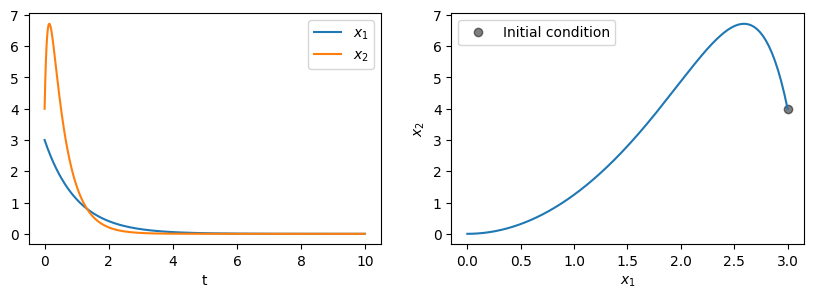

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(t_train, x_train[:, 0], label='$x_1$')
axs[0].plot(t_train, x_train[:, 1], label='$x_2$')
axs[0].set(xlabel='t')
axs[0].legend()

axs[1].plot(x_train[0, 0], x_train[0, 1], 'o', color='black', label="Initial condition", alpha=0.5)
axs[1].plot(x_train[:, 0], x_train[:, 1])
axs[1].set(xlabel='$x_1$', ylabel='$x_2$')
axs[1].legend();

In [ ]:
def plot_observables(observables, x, t, input_features=None, t_delay=None):
    '''Generate plots of state variables before and after being transformed into new observables.'''
    n_features = x.shape[1]
    if input_features is None:
        input_features = [f'x{i}' for i in range(n_features)]
    if t_delay is None:
        t_delay = t

    # Plot input features (state variables)
    fig, axs = plt.subplots(1, n_features, figsize=(n_features * 5, 3))

    for ax, k, feat_name in zip(axs, range(n_features), input_features):
        ax.plot(t, x[:, k])
        ax.set(xlabel='t', title=feat_name)
    fig.suptitle('Original state variables')
    fig.tight_layout()
    # fig.show()

    # Plot output features
    y = observables.fit_transform(x)

    n_output_features = observables.n_output_features_
    feature_names = observables.get_feature_names(input_features)

    n_rows = (n_output_features // 3) + (n_output_features % 3 > 0)
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows), sharex=True)

    for ax, k, feat_name in zip(axs.flatten(), range(n_output_features), feature_names):
        ax.plot(t_delay, y[:, k])
        ax.set(xlabel='t', title=feat_name)

    fig.suptitle('Observables')
    fig.tight_layout()
    # fig.show()
    return

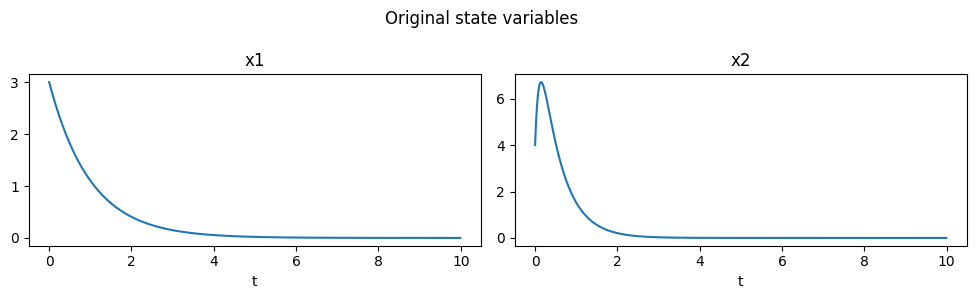

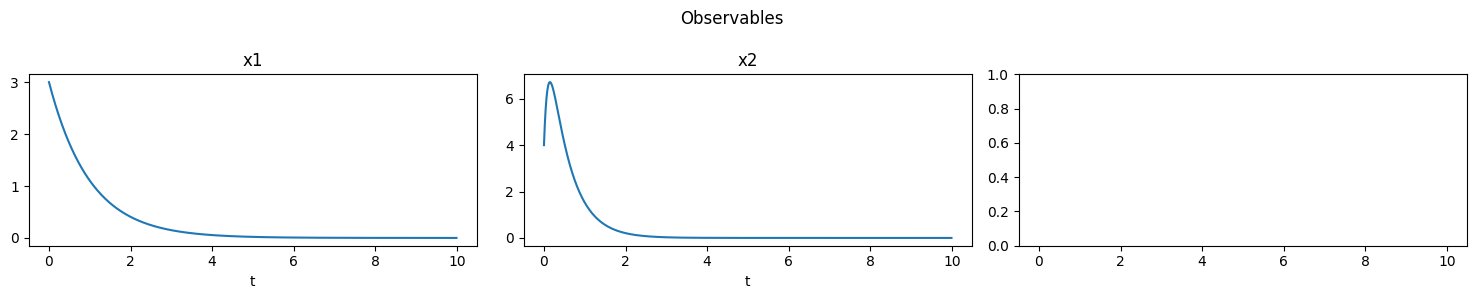

In [ ]:
obs = pk.observables.Identity()
plot_observables(obs, x_train, t_train, input_features=input_features)

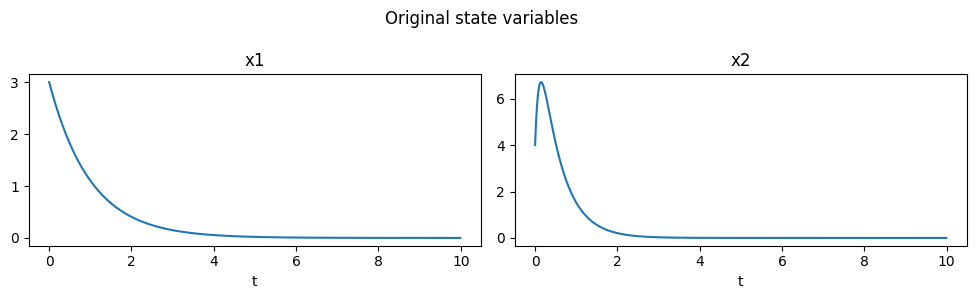

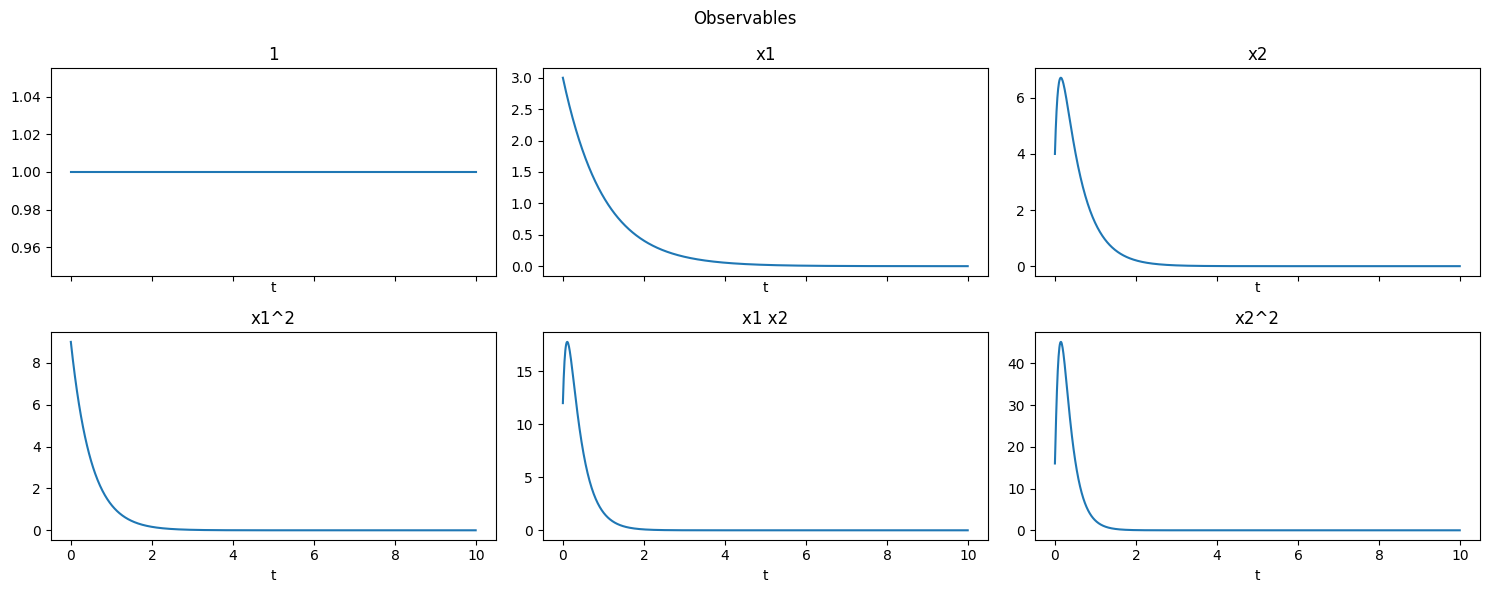

In [ ]:
obs = pk.observables.Polynomial(degree=2)
plot_observables(obs, x_train, t_train, input_features=input_features)

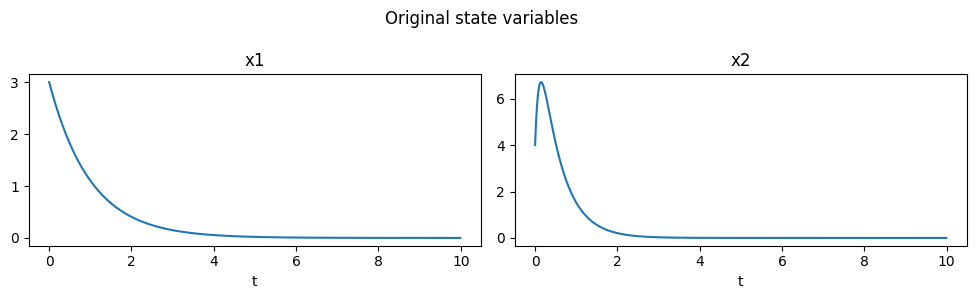

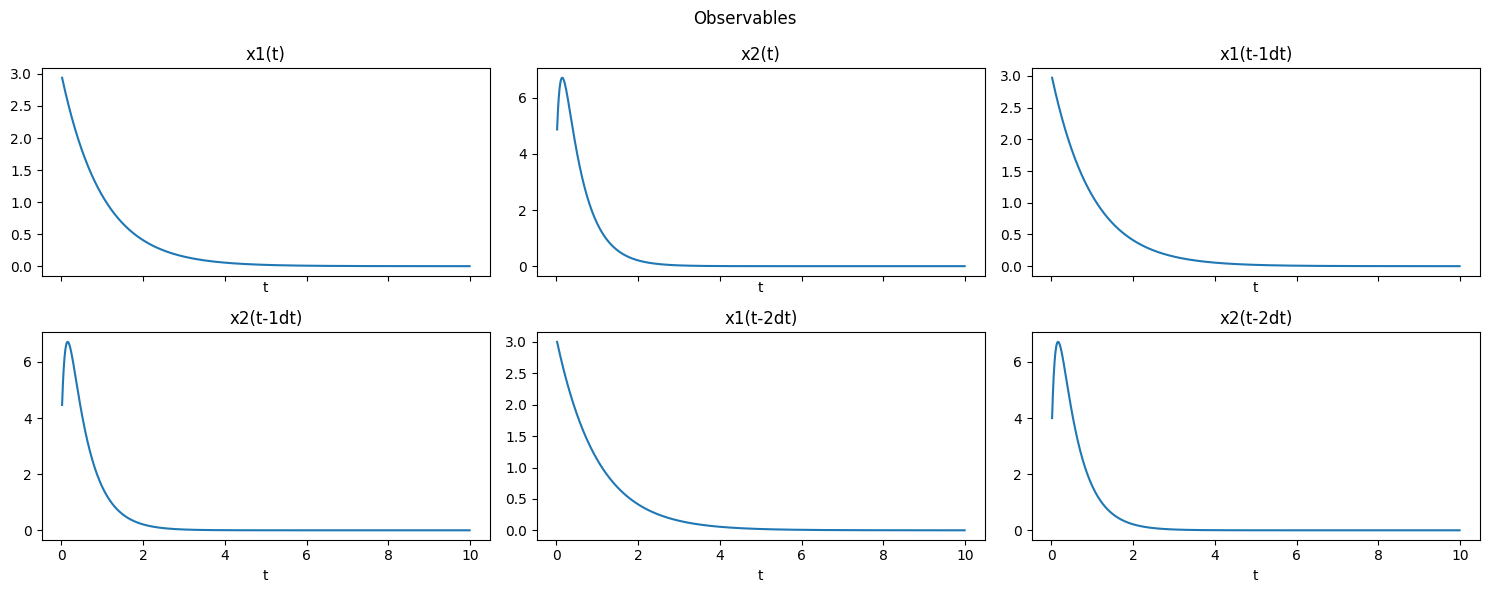

In [ ]:
delay = 1 # dt
n_delays = 2
obs = pk.observables.TimeDelay(delay=delay, n_delays=n_delays)

t_delay = t_train[delay * n_delays:]
plot_observables(obs, x_train, t_train, input_features=input_features, t_delay=t_delay)

In [ ]:
print("Number of output features: ",obs.n_output_features_)
print("Shape of data: ",obs.fit_transform(x_train).shape)
print("Features Name: ",obs.get_feature_names())

Number of output features:  6
Shape of data:  (998, 6)
Features NAme:  ['x0(t)', 'x1(t)', 'x0(t-1dt)', 'x1(t-1dt)', 'x0(t-2dt)', 'x1(t-2dt)']


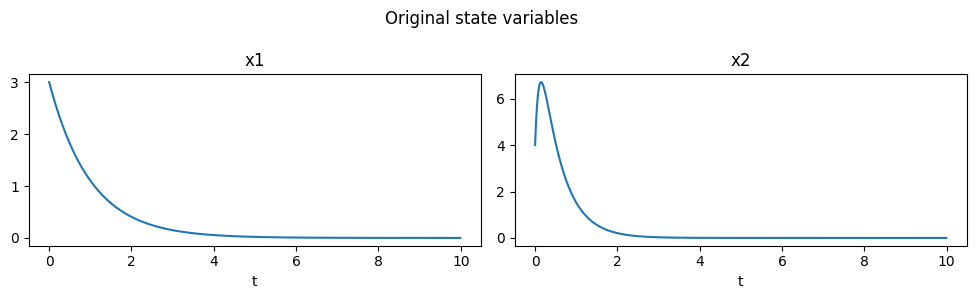

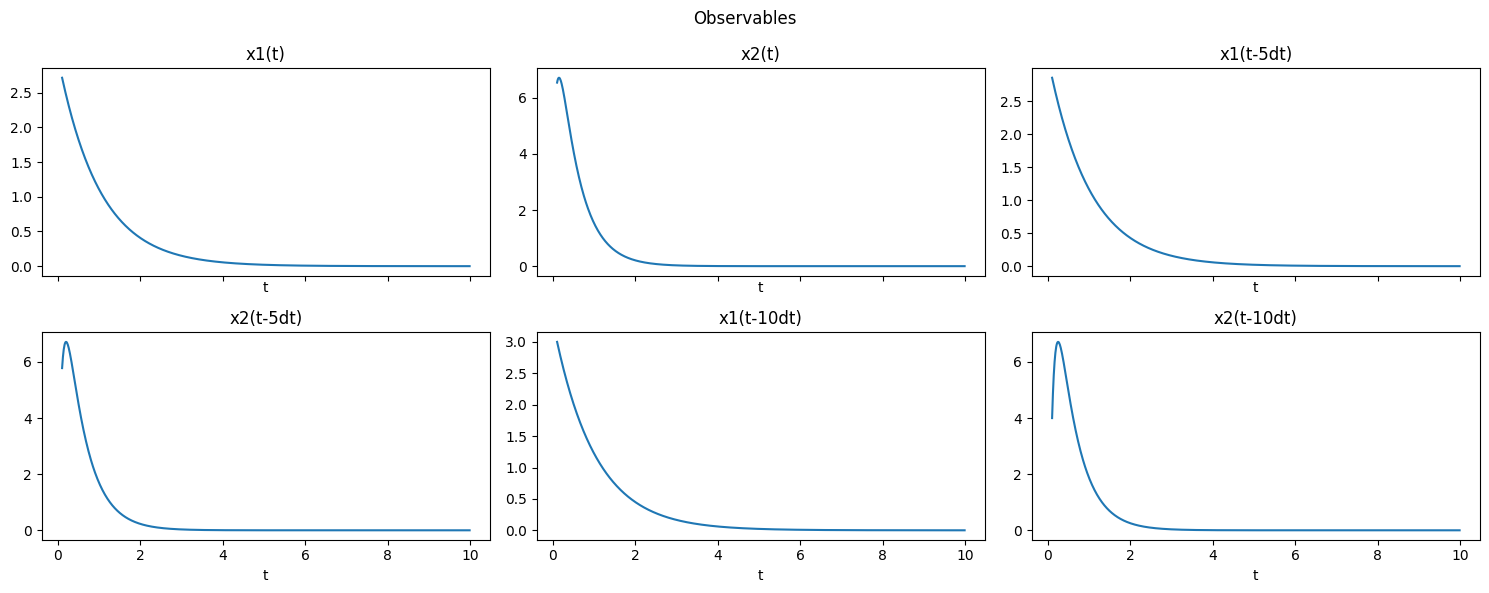

In [ ]:
delay = 5 # dt
n_delays = 2
obs = pk.observables.TimeDelay(delay=delay, n_delays=n_delays)

t_delay = t_train[delay * n_delays:]
plot_observables(obs, x_train, t_train, input_features=input_features, t_delay=t_delay)

In [ ]:
print("Number of output features: ",obs.n_output_features_)
print("Shape of data: ",obs.fit_transform(x_train).shape)
print("Features Name: ",obs.get_feature_names())

Number of output features:  8
Shape of data:  (1000, 8)
Features Name:  ['x0', 'x1', "cos(w_0'x)/sqrt(3)", "cos(w_1'x)/sqrt(3)", "cos(w_2'x)/sqrt(3)", "sin(w_0'x)/sqrt(3)", "sin(w_1'x)/sqrt(3)", "sin(w_2'x)/sqrt(3)"]


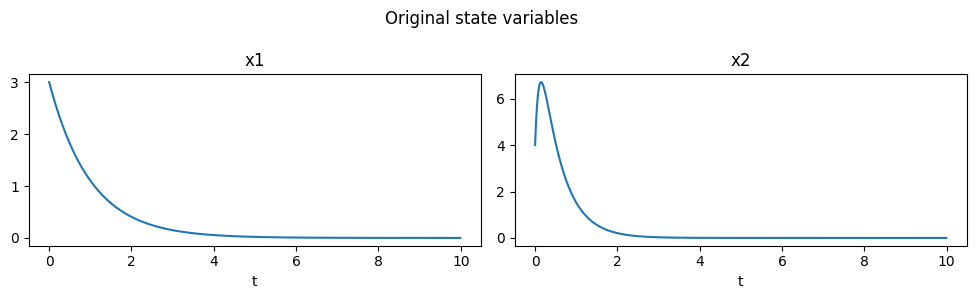

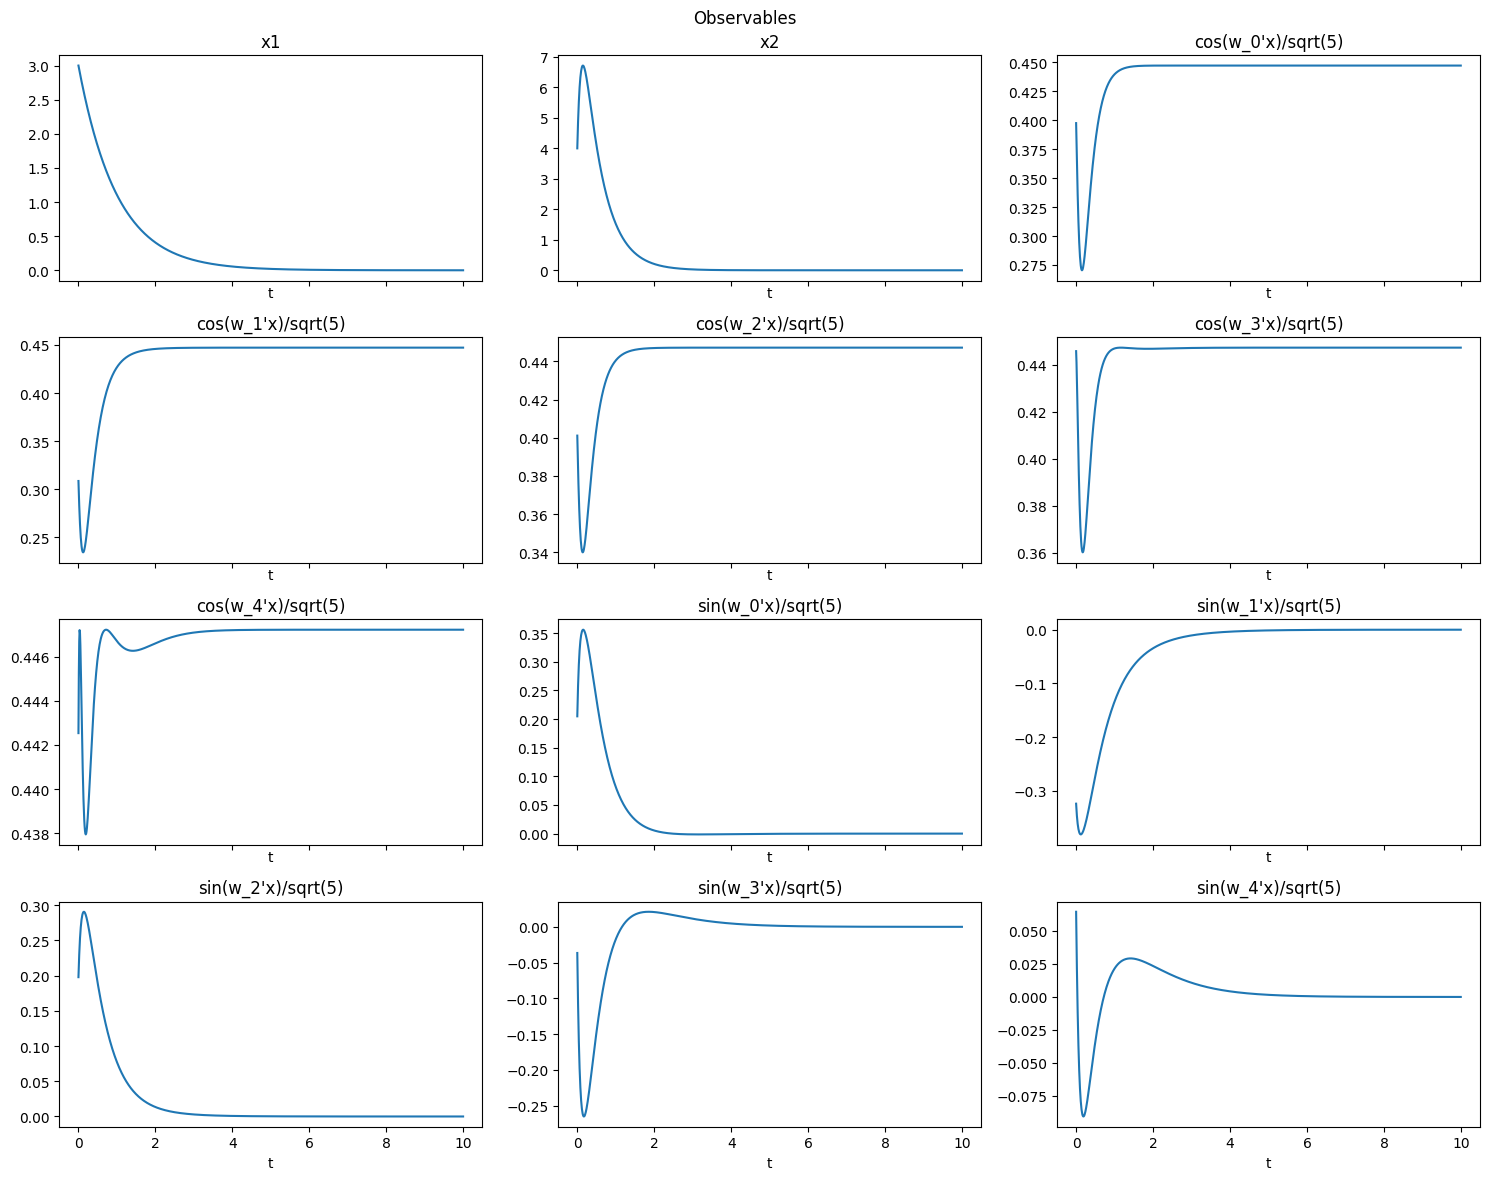

In [29]:
# with state
obs = pk.observables.RandomFourierFeatures(include_state=True,gamma=0.01,D=5)
plot_observables(obs, x_train, t_train, input_features=input_features)

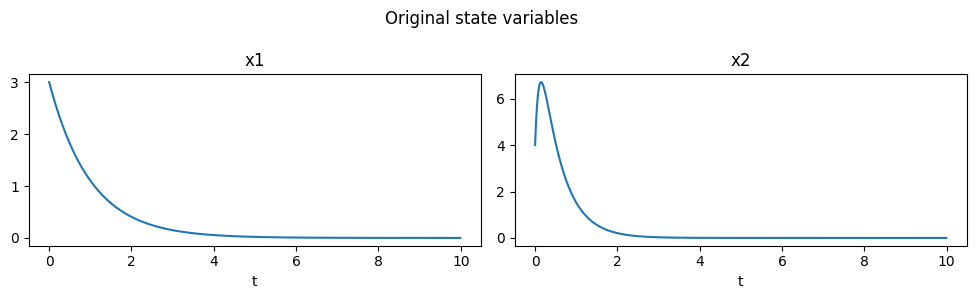

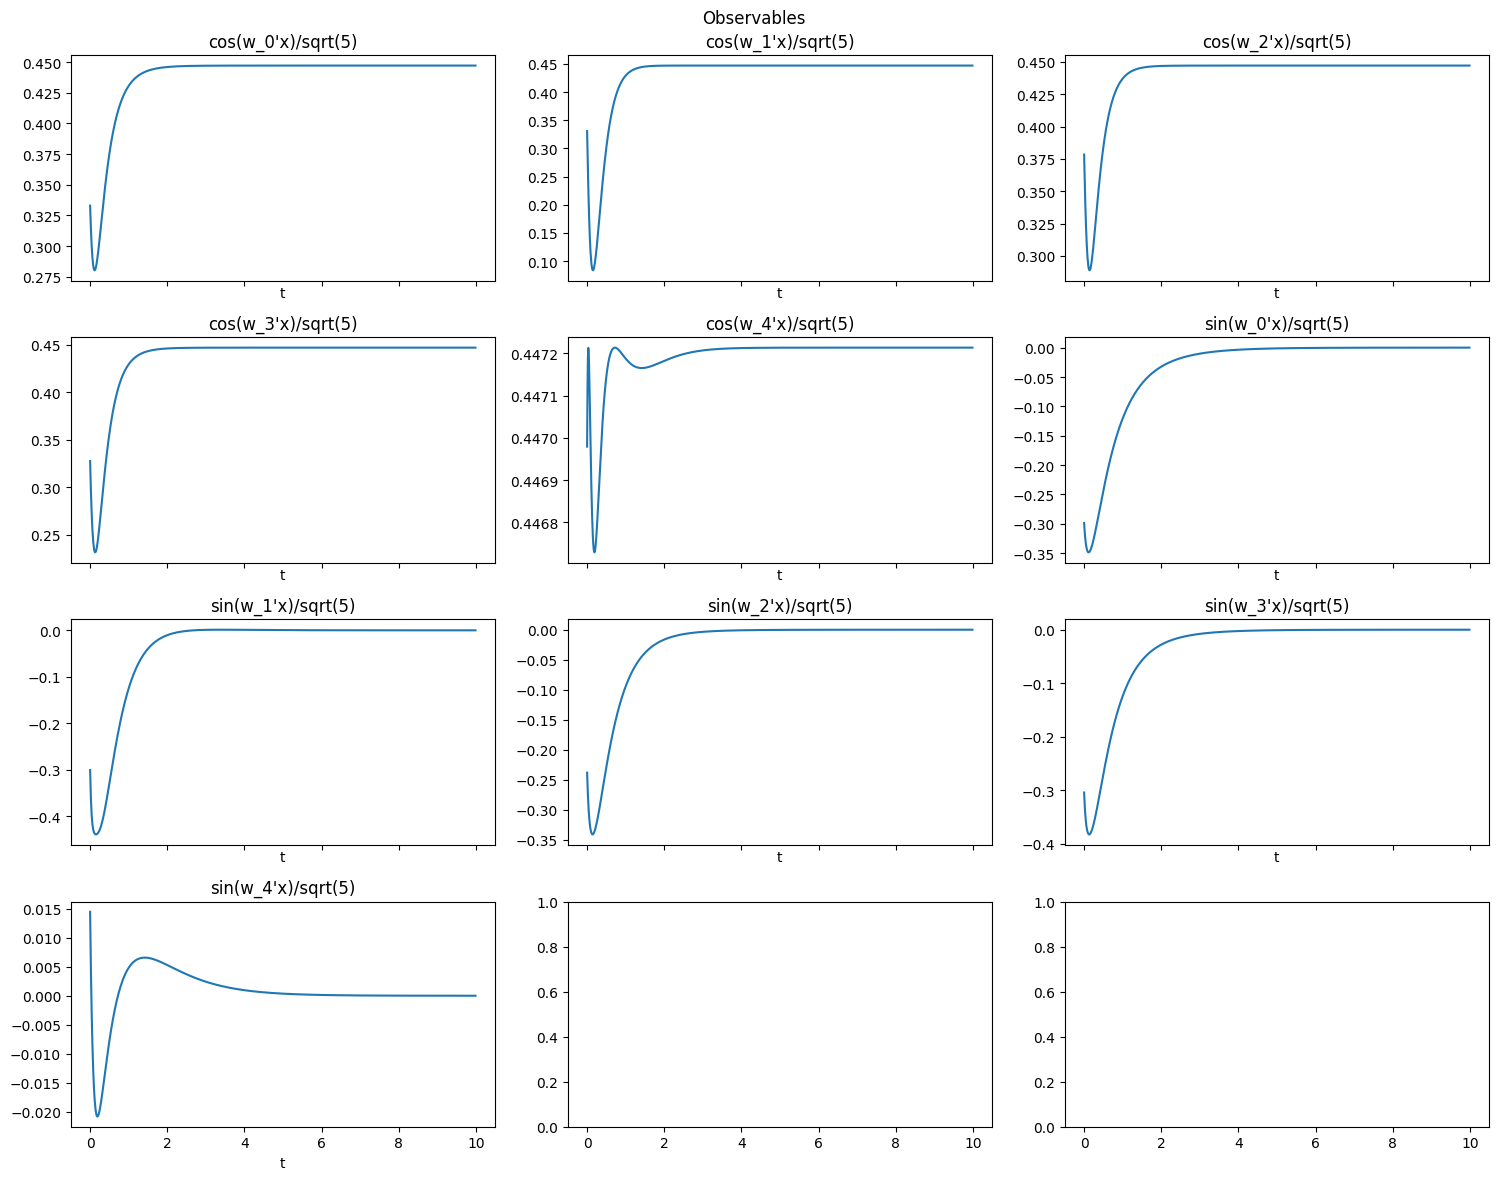

In [26]:
# without state
obs = pk.observables.RandomFourierFeatures(include_state=False,gamma=0.01,D=5)
plot_observables(obs, x_train, t_train, input_features=input_features)

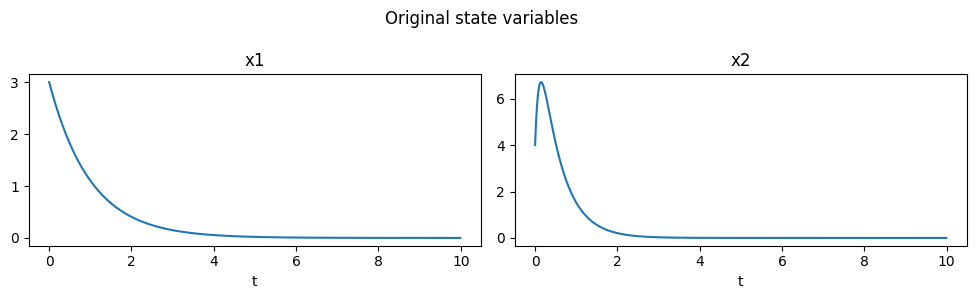

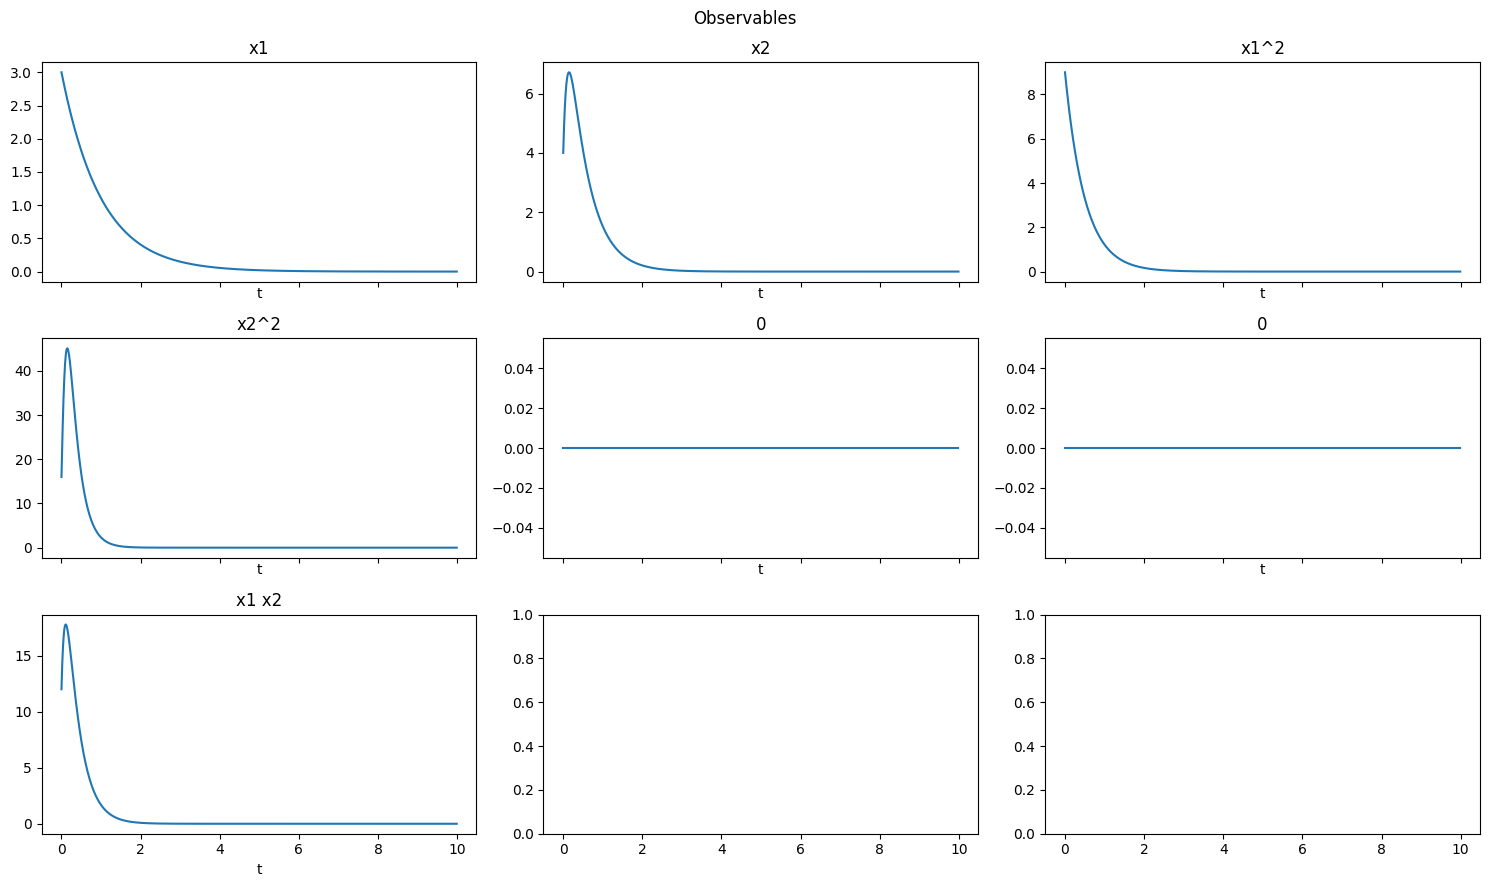

In [36]:
observables = [lambda x: x ** 2, lambda x: 0 * x, lambda x, y: x * y]
observable_names = [
    lambda s: f"{s}^2",
    lambda s: str(0),
    lambda s, t: f"{s} {t}",
]

obs = pk.observables.CustomObservables(observables, observable_names=observable_names)
plot_observables(obs, x_train, t_train, input_features=input_features)

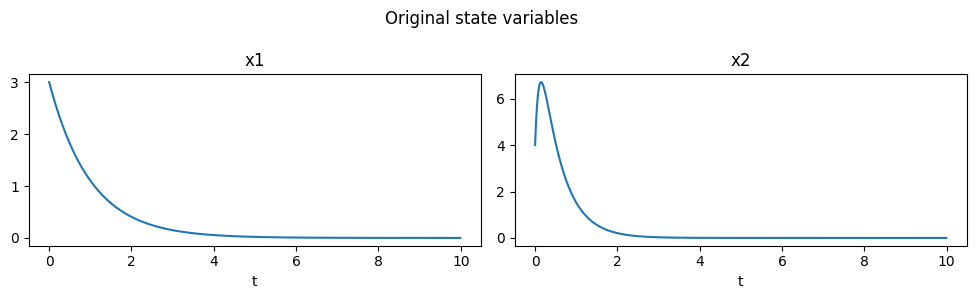

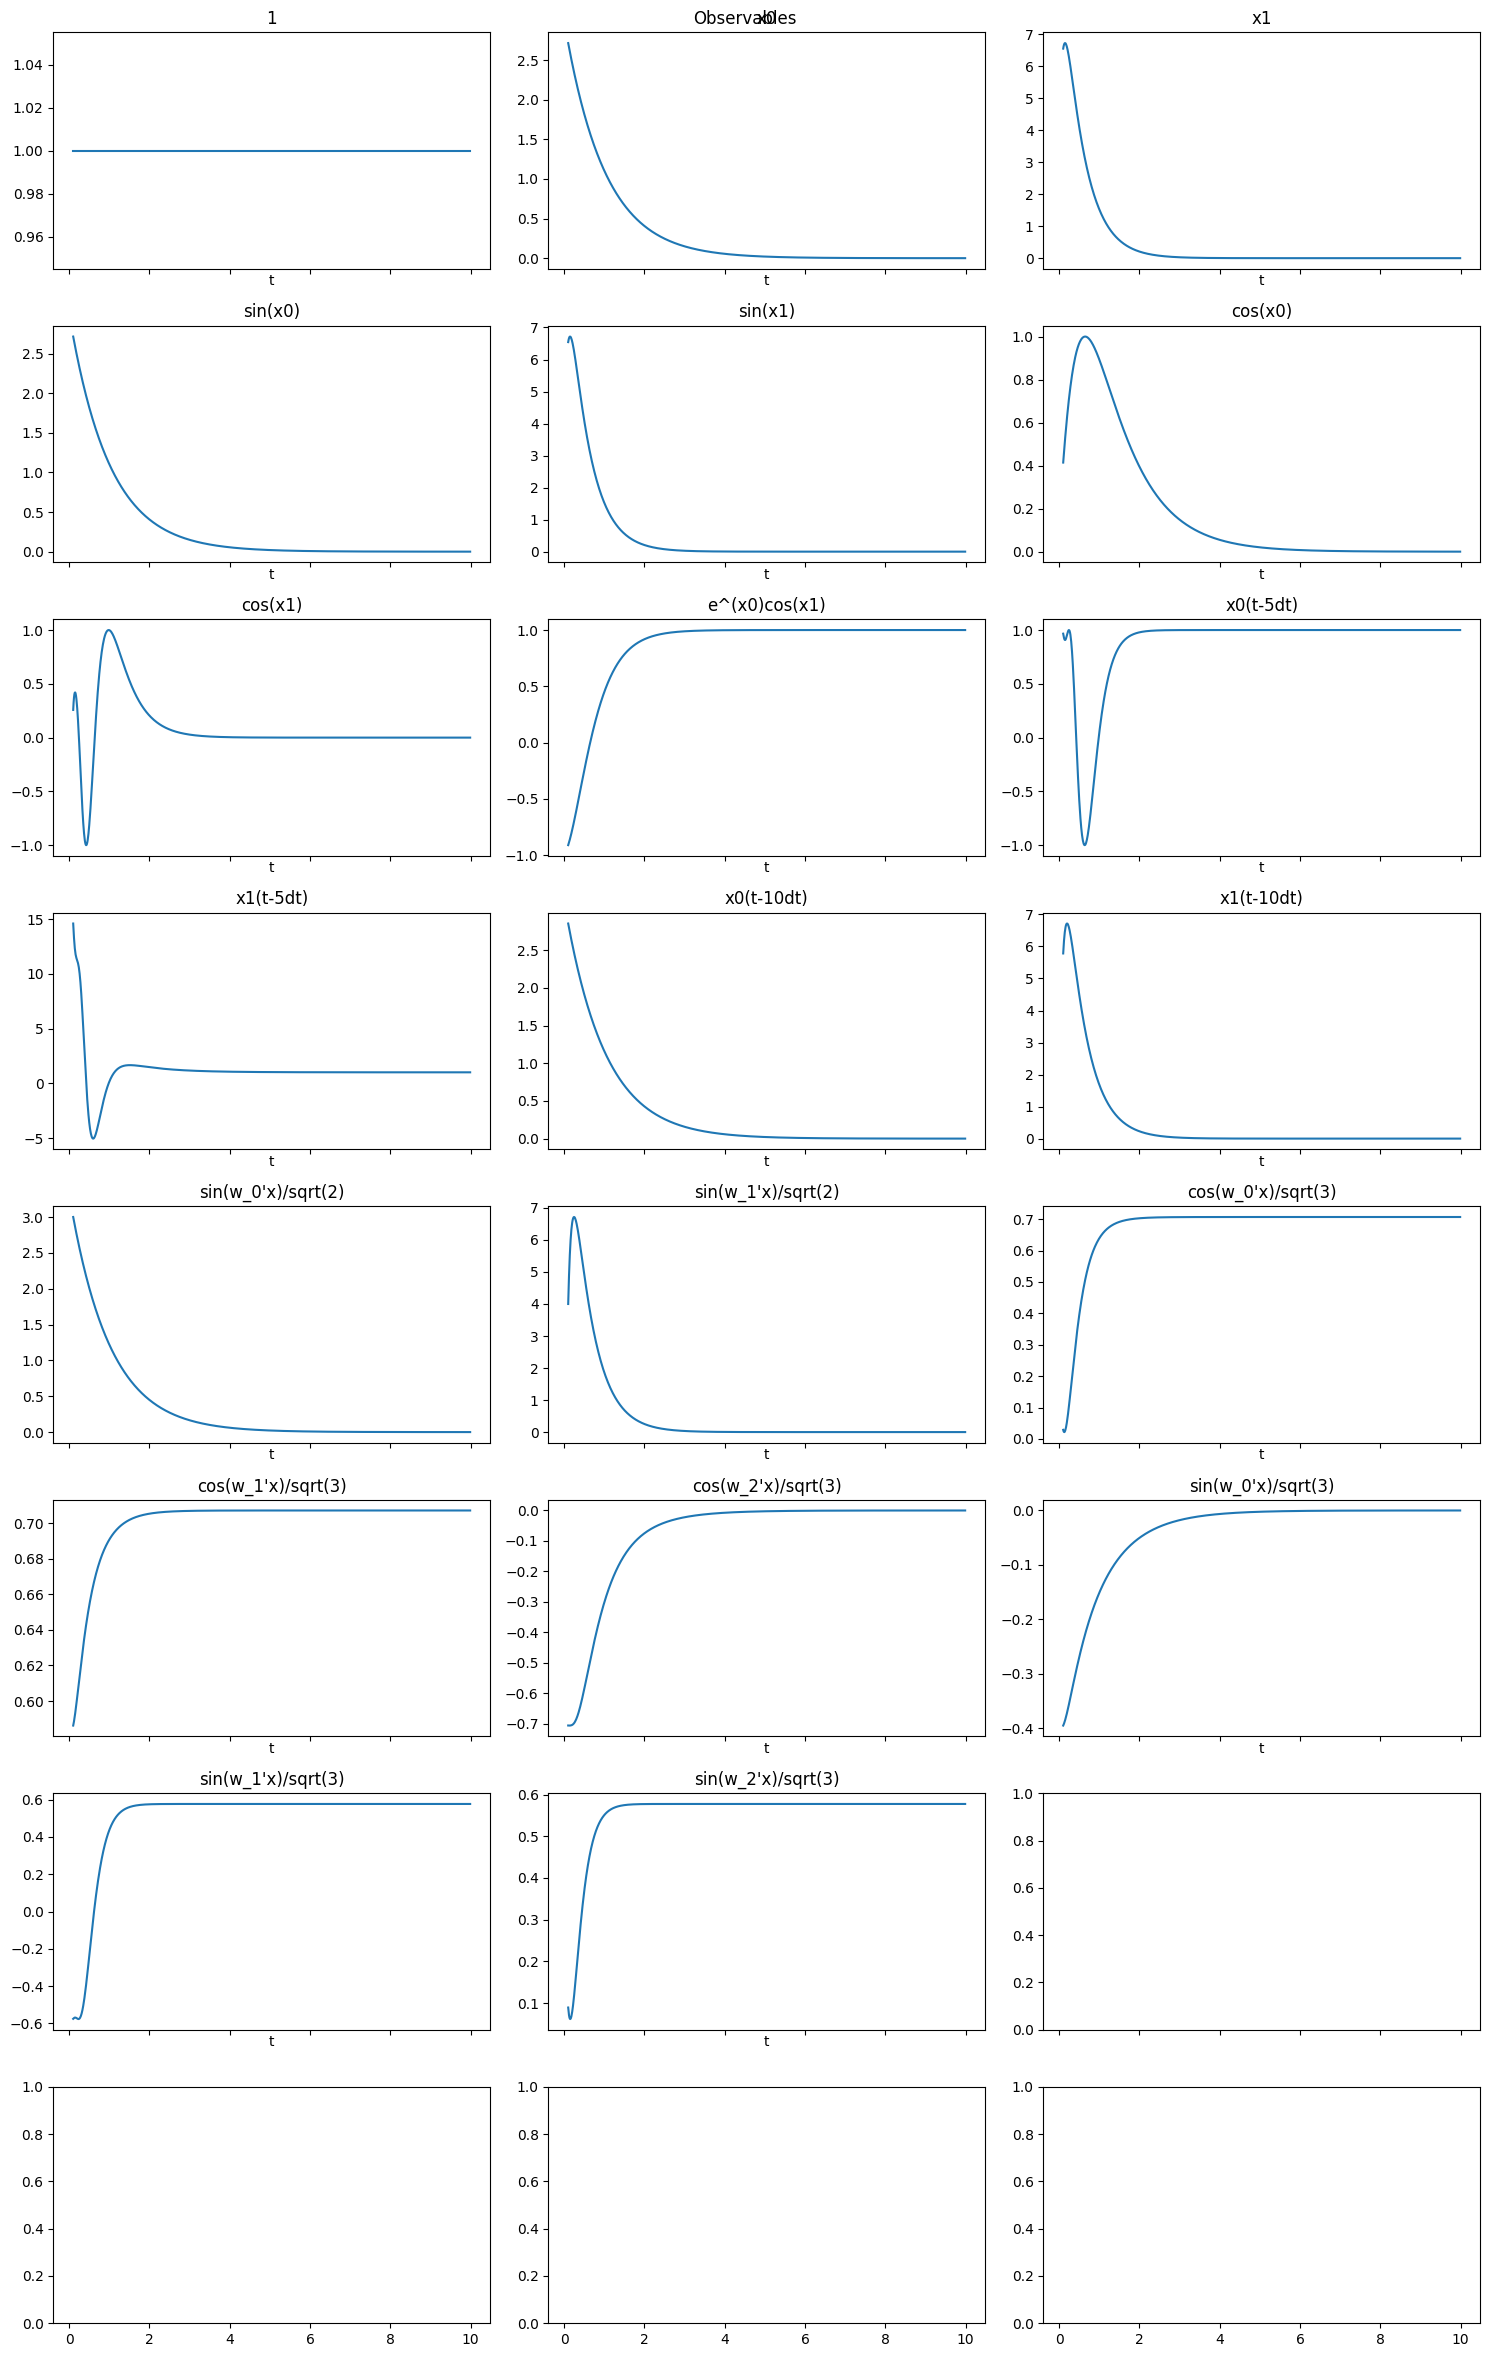

In [31]:
# first observable: from Polynomial combinations
ob1 = pk.observables.Polynomial(degree=1)

# second observable: from CustomObservables of univariate functions
observables = [lambda x: np.sin(x), lambda x: np.cos(x), lambda x, y: np.exp(x)*np.cos(y)]
observable_names = [
    lambda s: f"sin({s})",
    lambda s: f"cos({s})",
    lambda s, t: f"e^({s})cos({t})",
]
ob2 = pk.observables.CustomObservables(observables, observable_names=observable_names)

# third observable: a time delay observable
delay = 5 # dt
n_delays = 2
t_delay = t_train[delay * n_delays:]
ob3 = pk.observables.TimeDelay(delay=delay, n_delays=n_delays)


# fourth observable: random fourier feature without state
ob4 = pk.observables.RandomFourierFeatures(include_state=False,gamma=0.01,D=2)

# fifth observable: random fourier feature with state
ob5 = pk.observables.RandomFourierFeatures(include_state=True,gamma=0.1,D=3)


obs = ob1 + ob2 + ob3 + ob4 + ob5
plot_observables(obs, x_train, t_train, input_features=input_features, t_delay=t_delay)

In [33]:
print("Number of output features: ",obs.n_output_features_)
print("Shape of data: ",obs.fit_transform(x_train).shape)

Number of output features:  24
Shape of data:  (990, 24)
